# Set up

In [1]:
# !pip install GDAL==$(gdal-config --version)
# !pip install pyproj geopandas
# %pip install segment-geospatial
# !pip install -q monai
!pip install torch torchvision
!pip install datasets
from IPython import display
import os
from samgeo import SamGeo, tms_to_geotiff
from osgeo import gdal
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
display.clear_output()
print("package installed")

package installed


# Load LangSAM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# need to do git clone https://github.com/luca-medeiros/lang-segment-anything && cd lang-segment-anything at terminal
%cd /content/drive/MyDrive/lang-segment-anything

/content/drive/MyDrive/lang-segment-anything


In [3]:
!pip install torch torchvision
from IPython import display
display.clear_output()

In [ ]:
# need to restart session here
!pip install -e .

In [2]:
from PIL import Image
from lang_sam import LangSAM
model_lang = LangSAM()

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:35

final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Prepare the data

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("back2classroom/sidewalks_chunk4", split='train', streaming=True)
dataset_val = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

In [4]:
import io
from PIL import Image
import numpy as np

# filter the dataset with sidewalk
def is_entirely_same_color(image_stream):
    image = Image.open(image_stream)
    np_image = np.array(image)
    # check if all pixel values are the same as the first pixel
    return np_image.max()==0

def filter_records(dataset, max_records=None):
    filtered_records = []
    records_processed = 0

    for data in dataset:
        label_image_stream = io.BytesIO(data['label_tif'])

        # Check if the label image is not entirely the same color
        if not is_entirely_same_color(label_image_stream):
            filtered_records.append(data)
            records_processed += 1

            # Check if max_records is reached
            if max_records is not None and records_processed >= max_records:
                break
    return filtered_records

filtered_dataset = filter_records(dataset)
filtered_dataset_val = filter_records(dataset_val)

# Load SamModel and SamProcessor

In [5]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_sw_model = SamModel(config=model_config)

#Update the model by loading the weights from saved file.
my_sw_model.load_state_dict(torch.load("/content/drive/MyDrive/Project/sidewalk_model_epoch10.pth"))

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_sw_model.to(device)

# Get mask without visual prompt

In [7]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [8]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = Image.open(io.BytesIO(item["tif"]))
    ground_truth_mask = np.array(Image.open(io.BytesIO(item['label_tif'])))
    filename = item["filename"]

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    inputs["image"] = np.array(image)
    inputs["filename"] = filename

    return inputs

In [9]:
def get_mask_without_prompt(idx, filtered_dataset, processor, model):
  sam_dataset = SAMDataset(dataset=filtered_dataset, processor=processor) # create an instance of SAMDataset
  item = sam_dataset[idx]
  image = item["image"]
  ground_truth_mask = item["ground_truth_mask"]
  filename=filtered_dataset[idx]["filename"]
  prompt = get_bounding_box(ground_truth_mask)
  inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt") # prepare image + box prompt for the model
  inputs = {k: v.to(device) for k, v in inputs.items()}
  model.eval()
  # forward pass
  with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)) # apply sigmoid
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze() # convert soft mask to hard mask
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))
  axes[0].imshow(np.array(image), cmap='gray')
  axes[0].set_title(f"Image {filename}")
  axes[0].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[1].imshow(medsam_seg, cmap='gray')
  axes[1].set_title("Predicted Mask No Prompt")
  axes[1].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[2].imshow(medsam_seg_prob)
  axes[2].set_title("Predicted Prob Map No Prompt")
  axes[2].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[3].imshow(np.array(ground_truth_mask), cmap='gray')
  axes[3].set_title("Ground Truth Mask")
  axes[3].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)

  tick_interval = 20
  for ax in axes:
      ax.set_xticks(np.arange(0, np.array(image).shape[1], tick_interval))
      ax.set_yticks(np.arange(0, np.array(image).shape[0], tick_interval))
      ax.set_xticklabels(np.arange(0, np.array(image).shape[1], tick_interval), fontsize=8)
      ax.set_yticklabels(np.arange(0, np.array(image).shape[0], tick_interval), fontsize=8)

  plt.show()


# Sidewalk prompter

In [10]:
import matplotlib.patches as patches
def sidewalk_prompter(idx, filtered_dataset,
                      processor, model, model_lang,
                      input_points_arr, input_labels_arr,
                      threshold_min, threshold_max, bbox_user):
  input_points = torch.tensor(input_points_arr, dtype=torch.float).unsqueeze(0)
  input_labels = torch.tensor(input_labels_arr, dtype=torch.int).unsqueeze(0)
  sam_dataset = SAMDataset(dataset=filtered_dataset, processor=processor) # create an instance of SAMDataset
  item = sam_dataset[idx]
  image = item["image"]
  ground_truth_mask = item["ground_truth_mask"]
  filename=filtered_dataset[idx]["filename"]
  prompt = get_bounding_box(ground_truth_mask) #[x_min, y_min, x_max, y_max]
  input_boxes=[[prompt],[bbox_user]]

  inputs = processor(image, input_boxes=input_boxes, input_points=input_points, input_labels=input_labels, return_tensors="pt")
  # inputs = processor(image, input_boxes=input_boxes, return_tensors="pt")
  inputs['input_boxes'] = inputs['input_boxes'].view(1, 2, 4)
  inputs = {k: v.to(device) for k, v in inputs.items()}
  model.eval()
  with torch.no_grad():
      outputs = model(**inputs, multimask_output=False) # forward pass
  mask_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)) # apply sigmoid
  mask_prob = mask_prob.cpu().numpy().squeeze() # convert soft mask to hard mask
  mask = (mask_prob > 0.5).astype(np.uint8)

  masks, boxes, phrases, logits = model_lang.predict(Image.open(io.BytesIO(filtered_dataset[idx]['tif'])), "tree")

  mask_prob_enhanced = mask_prob.copy()
  found_tree=True
  if boxes is None or len(boxes) == 0:
    found_tree=False
  else:
    for box, logit in zip(boxes, logits):
      if logit<0.5:
        continue
      # enhance the model predicted tree bbox
      x1, y1, x2, y2 = box
      roi = mask_prob[0][int(y1):int(y2), int(x1):int(x2)]
      roi[(roi >= threshold_min) & (roi <= threshold_max)] = 0.4
      mask_prob_enhanced[0][int(y1):int(y2), int(x1):int(x2)] = roi

  # enhance the user input bbox
  x1, y1, x2, y2 = bbox_user
  roi = mask_prob[0][int(y1):int(y2), int(x1):int(x2)]
  roi[(roi >= threshold_min) & (roi <= threshold_max)] = 0.4
  mask_prob_enhanced[0][int(y1):int(y2), int(x1):int(x2)] = roi
  mask = (mask_prob_enhanced >=0.4).astype(np.uint8)

  fig, axes = plt.subplots(1, 4, figsize=(15, 5))
  axes[0].imshow(np.array(image), cmap='gray')
  axes[0].set_title(f"Image {filename}")
  axes[0].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[1].imshow(mask[0], cmap='gray')
  axes[1].set_title("Predicted Mask With Prompt")
  axes[1].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[2].imshow(mask_prob[0])
  axes[2].set_title("Predicted Prob Map With Prompt")
  axes[2].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)
  axes[3].imshow(np.array(ground_truth_mask), cmap='gray')
  axes[3].set_title("Ground Truth Mask")
  axes[3].grid(True, which='both', color='gray', linestyle='-', linewidth=0.5)

  for point in input_points_arr[1]:
    axes[0].scatter(point[0], point[1], color='b')

  # plot the model predicted tree bbox
  if found_tree:
    for box, logit in zip(boxes, logits):
      x_min, y_min, x_max, y_max = box
      confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
      box_width = x_max - x_min
      box_height = y_max - y_min
      rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
      axes[0].add_patch(rect)
      axes[0].text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

  # plot the user input bbox
  rect = plt.Rectangle((bbox_user[0], bbox_user[1]), bbox_user[2]-bbox_user[0], bbox_user[3]-bbox_user[1], linewidth=2, edgecolor='b', facecolor='none')
  axes[0].add_patch(rect)

  tick_interval = 20
  for ax in axes:
      ax.set_xticks(np.arange(0, np.array(image).shape[1], tick_interval))
      ax.set_yticks(np.arange(0, np.array(image).shape[0], tick_interval))
      ax.set_xticklabels(np.arange(0, np.array(image).shape[1], tick_interval), fontsize=8)
      ax.set_yticklabels(np.arange(0, np.array(image).shape[0], tick_interval), fontsize=8)

  plt.show()


# Test the visual prompt

In [ ]:
for idx, item in enumerate(filtered_dataset_val):
  if item["filename"] == "6_1_10":
    print(idx)
    break
else:
  raise ValueError("Record not found in the dataset.")

6988


## Try GUI for selecting points and bounding box

In [11]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()


In [13]:
%matplotlib ipympl

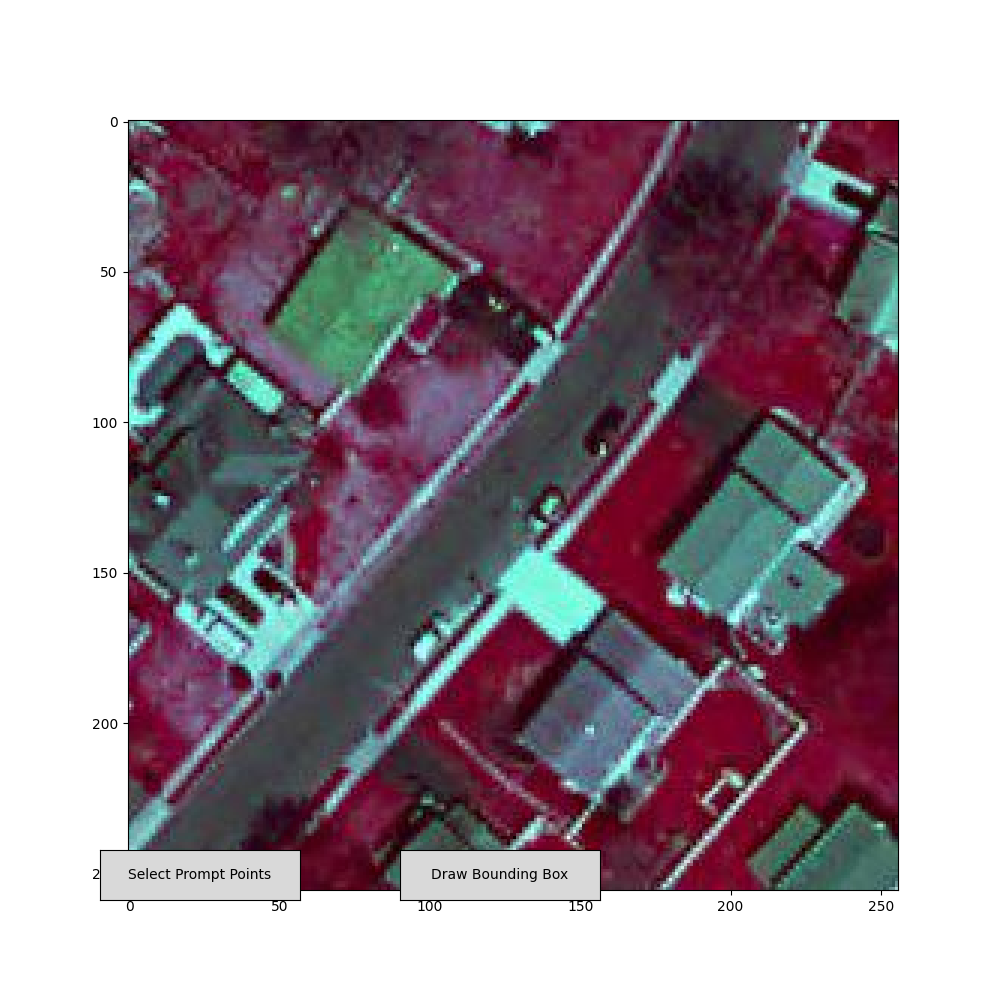

Drawing mode switched to 'Prompt Points'.
Drawing mode switched to 'Bounding Box'. Please click and drag to draw the bounding box.


In [57]:
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, Button
import numpy as np

# Global variables to store clicked points, labels, and bbox
points_array = []
bbox = None
drawing_mode = None  # Variable to store the current drawing mode
bbox_artist = None  # Variable to store the bounding box artist

test_image=SAMDataset(dataset=filtered_dataset_val, processor=processor)[9088]['image']

# Define a function to handle mouse click events
def on_click(event):
    global drawing_mode, bbox_artist, bbox
    # Check if the click happened within the image boundaries
    if event.xdata is not None and event.ydata is not None:
        if drawing_mode == "prompt_points":
            # Store the coordinates of the clicked point
            clicked_point = (event.xdata, event.ydata)

            # Append the clicked point coordinates to the points array
            points_array.append(clicked_point)

            # Update the plot to show the clicked point
            ax.plot(event.xdata, event.ydata, 'ro')
            plt.draw()

        elif drawing_mode == "bounding_box":
            # Clear the existing bounding box if it exists
            if bbox_artist:
                bbox_artist.remove()

            # Draw the bounding box
            bbox = (event.xdata, event.ydata)
            bbox_artist = ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), 0, 0, edgecolor='g', facecolor='none'))
            plt.draw()

# Define a function to handle rectangle selection
def on_rectangle_select(eclick, erelease):
    global bbox_artist, bbox
    # Clear the existing bounding box if it exists
    if bbox_artist:
        bbox_artist.remove()

    # Update the bounding box coordinates
    bbox = (eclick.xdata, eclick.ydata, erelease.xdata-eclick.xdata, erelease.ydata-eclick.ydata)
    bbox_artist = ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='g', facecolor='none'))
    plt.draw()

# Define a function to handle button click for selecting prompt points
def select_prompt_points(event):
    global drawing_mode
    drawing_mode = "prompt_points"
    print("Drawing mode switched to 'Prompt Points'.")

# Define a function to handle button click for drawing bounding boxes
def draw_bounding_box(event):
    global drawing_mode
    drawing_mode = "bounding_box"
    print("Drawing mode switched to 'Bounding Box'. Please click and drag to draw the bounding box.")

# Create a figure and display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(test_image)
ax.axis('on')

# Connect the mouse click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Create buttons for selecting prompt points and drawing bounding boxes
btn_select_points = Button(plt.axes([0.1, 0.1, 0.2, 0.05]), 'Select Prompt Points')
btn_select_points.on_clicked(select_prompt_points)

btn_draw_bbox = Button(plt.axes([0.4, 0.1, 0.2, 0.05]), 'Draw Bounding Box')
btn_draw_bbox.on_clicked(draw_bounding_box)

# Enable rectangle selection
rs = RectangleSelector(ax, on_rectangle_select, useblit=True, button=[1], interactive=True)

plt.show()


In [58]:
print(points_array)
points_array_copy=points_array.copy() # make a copy so that bbox selection won't affect the selected points

[(209.78571428571428, 41.723376623376595), (203.8012987012987, 52.02987012987012), (197.4844155844156, 62.336363636363615)]


In [59]:
print(bbox) #x_max, y_min, x_min, y_max
bbox_copy=bbox # make a copy so that points selection won't affect the selected bbox

(151.27142857142857, 8.809090909090912, 84.7792207792208, 120.35324675324674)


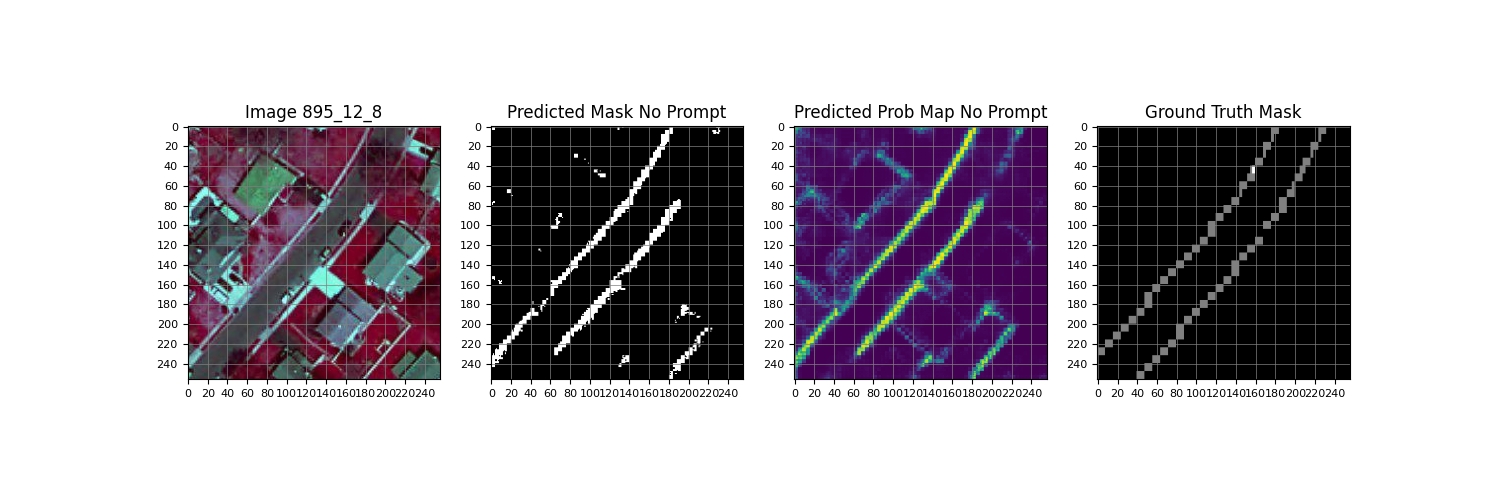

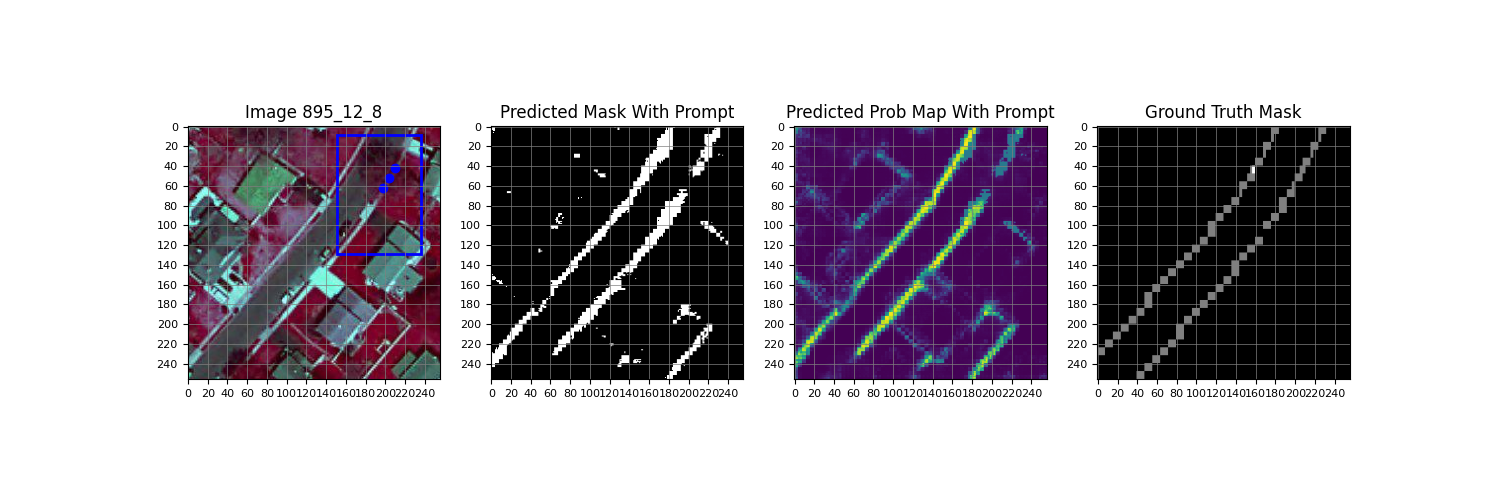

In [61]:
from pathlib import WindowsPath
get_mask_without_prompt(9088, filtered_dataset_val, processor, my_sw_model)
points_array_copy = np.array(points_array_copy)
input_points_arr = np.zeros((2, len(points_array_copy), 2))
input_points_arr[1] = points_array_copy
input_labels_arr = np.ones(len(points_array_copy), dtype=int)
x_min, y_min, width, height = bbox_copy
bbox_user = [x_min, y_min, x_min+width, y_min+height]
sidewalk_prompter(9088, filtered_dataset_val, processor, my_sw_model, model_lang,
                  input_points_arr, input_labels_arr,
                  0.08, 0.41, bbox_user)

## Test 10 images

### Image 1

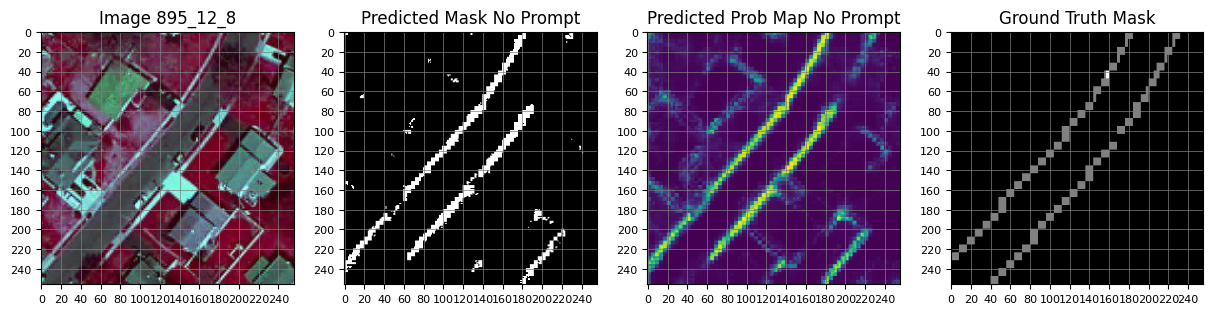

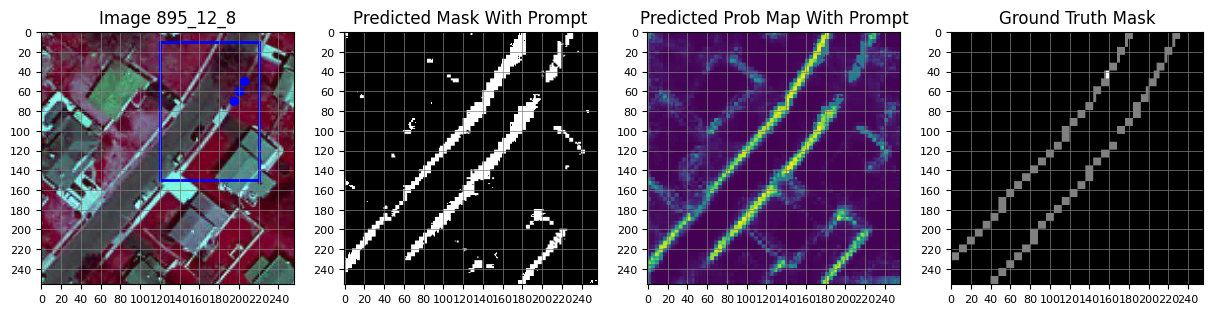

In [ ]:
get_mask_without_prompt(9088, filtered_dataset_val, processor, my_sw_model)
# input_points_arr = [[183, 62], [178, 71], [175, 72],[170, 76]]
input_points_arr = np.array([
    [[0, 0] for _ in range(3)],  # to match the number of points in the second box
    [[195,70],[200,60],[205,50]]
])
input_labels_arr = [[1,1,1]]
bbox_user = [120,10,220,150]
sidewalk_prompter(9088, filtered_dataset_val, processor, my_sw_model, model_lang,
                  input_points_arr, input_labels_arr,
                  0.1, 0.6, bbox_user)

### Image 2

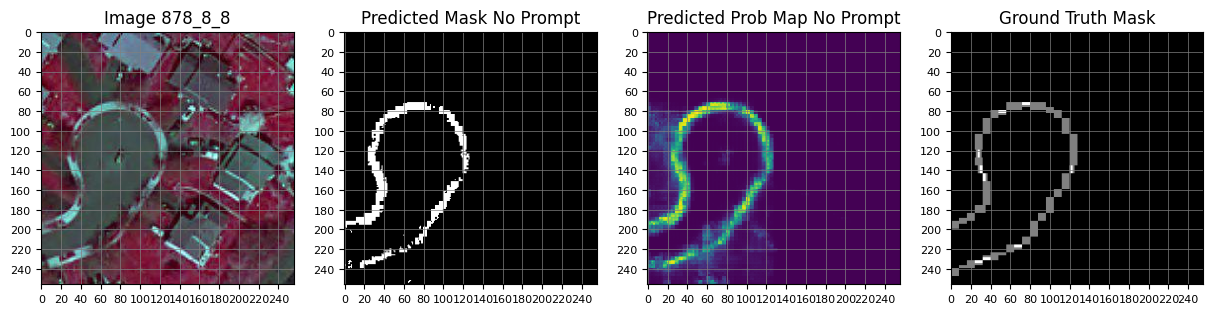

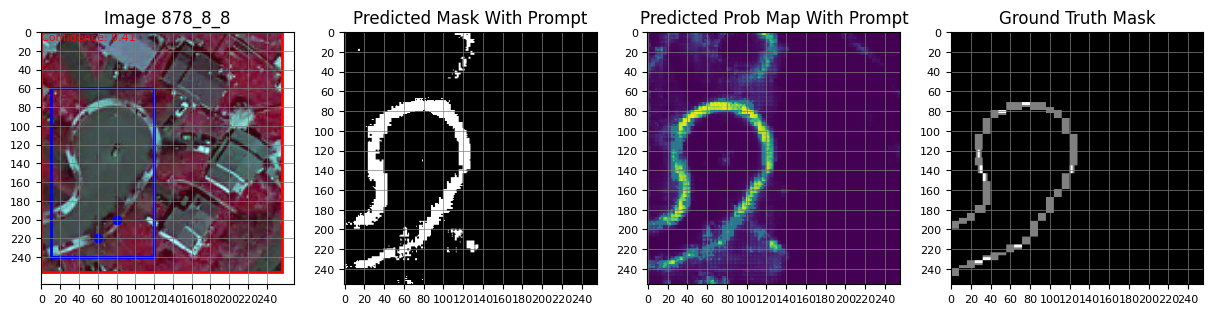

In [ ]:
get_mask_without_prompt(9029, filtered_dataset_val, processor, my_sw_model)
input_points_arr = np.array([
    [[0, 0] for _ in range(2)],  # to match the number of points in the second box
    [[60,220],[80,200]]
])
input_labels_arr = [[1,1]]
bbox_user = [10,60,120,240]
sidewalk_prompter(9029, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.2, 0.6, bbox_user)

### Image 3

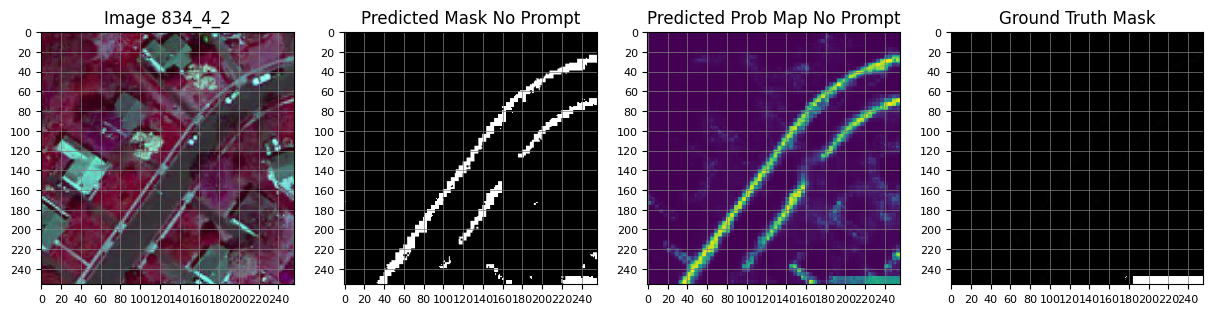

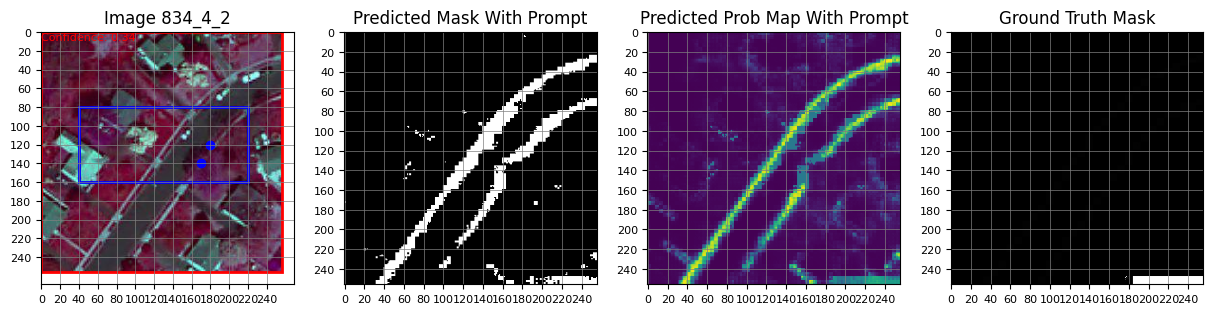

In [ ]:
get_mask_without_prompt(8465, filtered_dataset_val, processor, my_sw_model)
input_points_arr = np.array([
    [[0, 0] for _ in range(2)],  # to match the number of points in the second box
    [[170,140],[180,120]]
])
# input_points_arr = [[170,140]]
input_labels_arr = [[1]]
bbox_user = [40,80,220,160]
sidewalk_prompter(8465, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.1, 0.6, bbox_user)

### Image 4

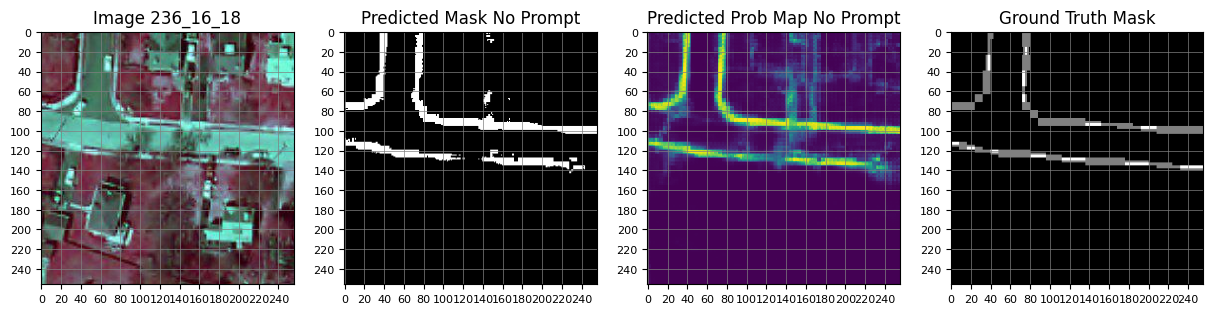

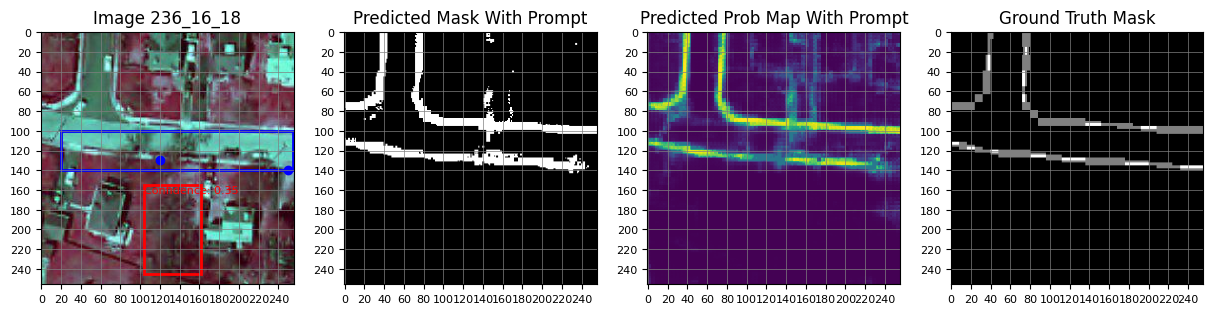

In [ ]:
get_mask_without_prompt(3479, filtered_dataset_val, processor, my_sw_model)
# input_points_arr = [[183, 62], [178, 71], [175, 72],[170, 76]]
input_points_arr = np.array([
    [[0, 0] for _ in range(2)],  # to match the number of points in the second box
    [[120,130],[250,140]]
])
input_labels_arr = [[1,1]]
bbox_user = [20,100,255,140]
sidewalk_prompter(3479, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.3, 0.6, bbox_user)

### Image 5

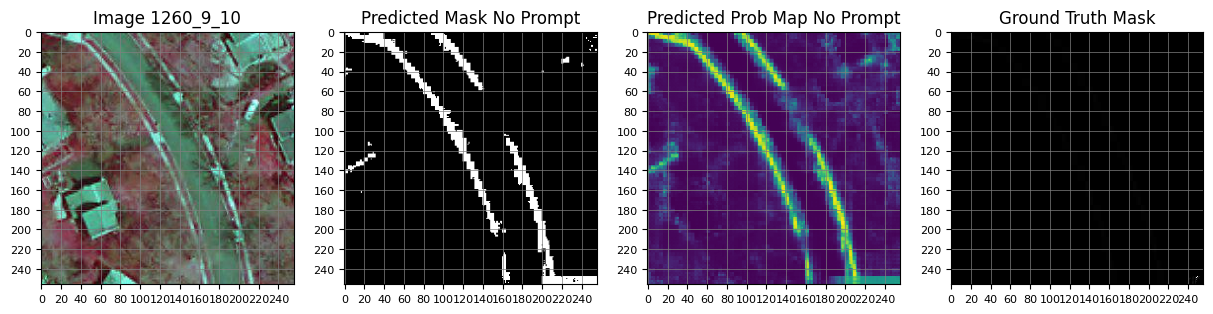

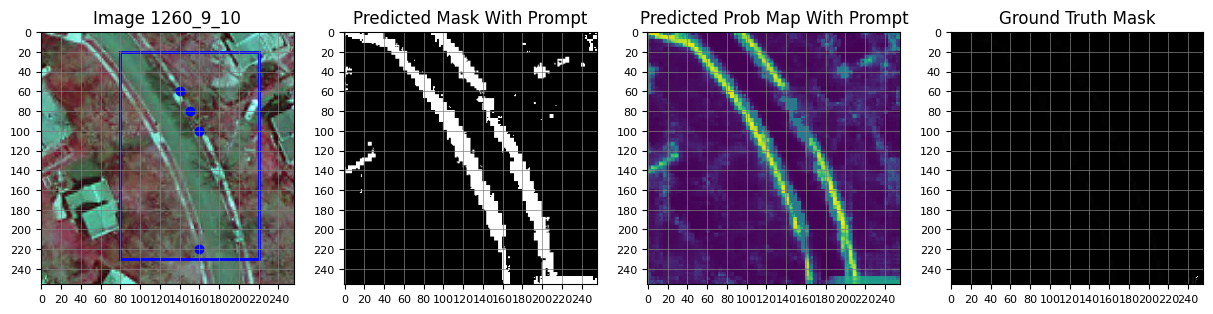

In [ ]:
get_mask_without_prompt(2308, filtered_dataset_val, processor, my_sw_model)
# input_points_arr = [[183, 62], [178, 71], [175, 72],[170, 76]]
input_points_arr = np.array([
    [[0, 0] for _ in range(4)],  # to match the number of points in the second box
    [[140,60],[150,80],[160,100],[160,220]]
])
input_labels_arr = [[1,1,1,1]]
bbox_user = [80,20,220,230]
sidewalk_prompter(2308, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.2, 0.6, bbox_user)

### Image 6

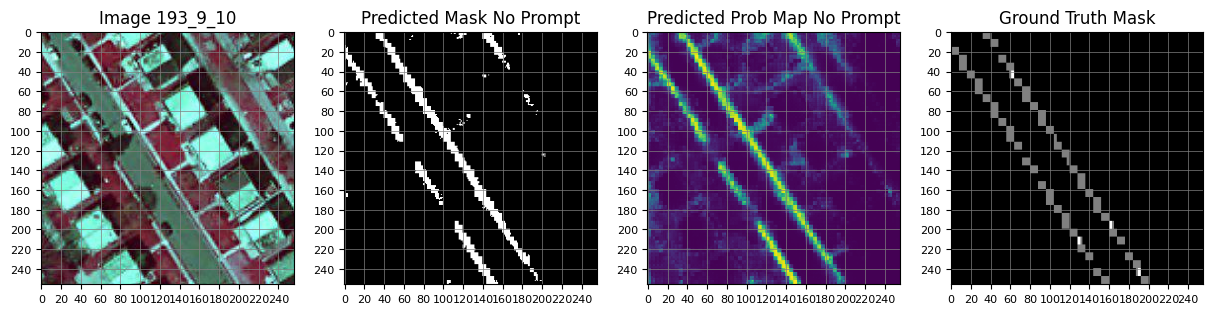

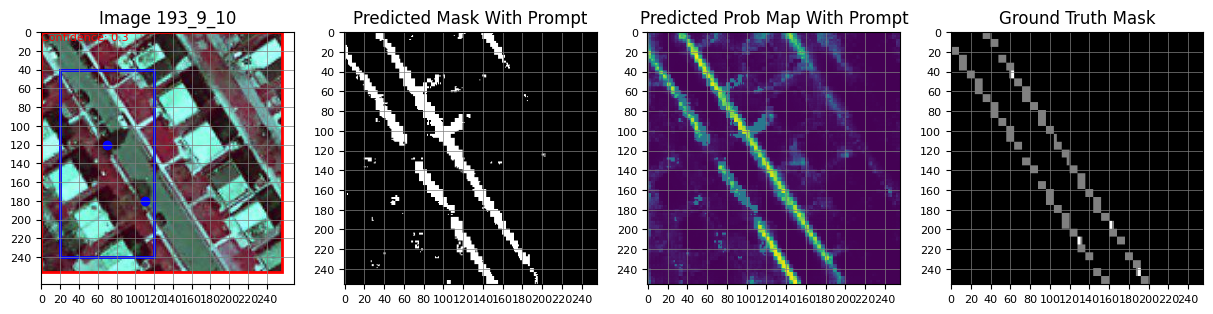

In [ ]:
get_mask_without_prompt(3346, filtered_dataset_val, processor, my_sw_model)
input_points_arr = np.array([
    [[0, 0] for _ in range(2)],  # to match the number of points in the second box
    [[70,120],[110,180]]
])
input_labels_arr = [[1,1]]
bbox_user = [20,40,120,240]
sidewalk_prompter(3346, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.1, 0.6, bbox_user)

### Image 7

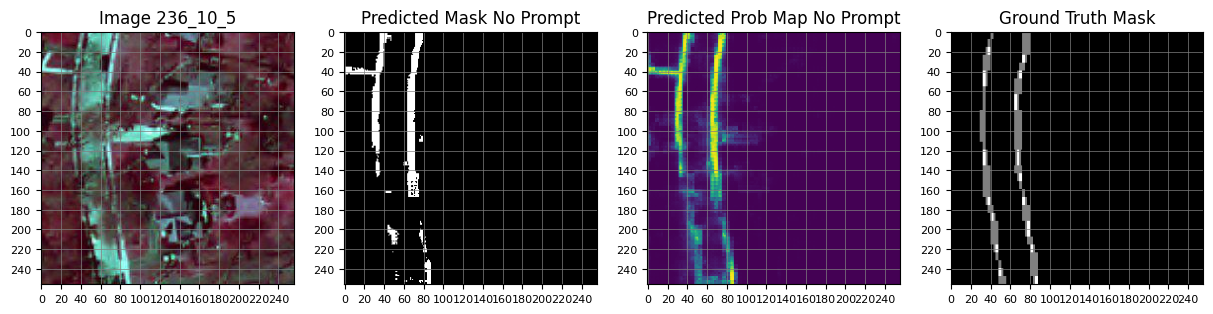

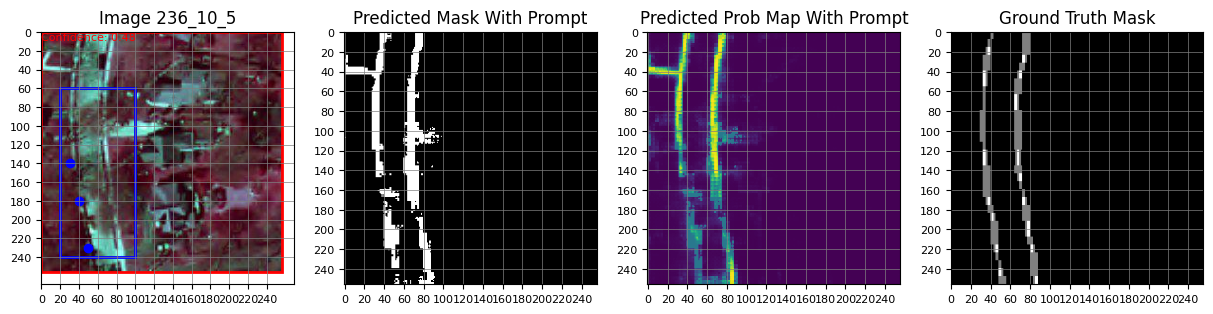

In [ ]:
get_mask_without_prompt(3376, filtered_dataset_val, processor, my_sw_model)
# input_points_arr = [[183, 62], [178, 71], [175, 72],[170, 76]]
input_points_arr = np.array([
    [[0, 0] for _ in range(3)],  # to match the number of points in the second box
    [[30,140],[40,180],[50,230]]
])
input_labels_arr = [[1,1,1]]
bbox_user = [20,60,100,240]
sidewalk_prompter(3376, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.15, 0.4, bbox_user)

### Image 8

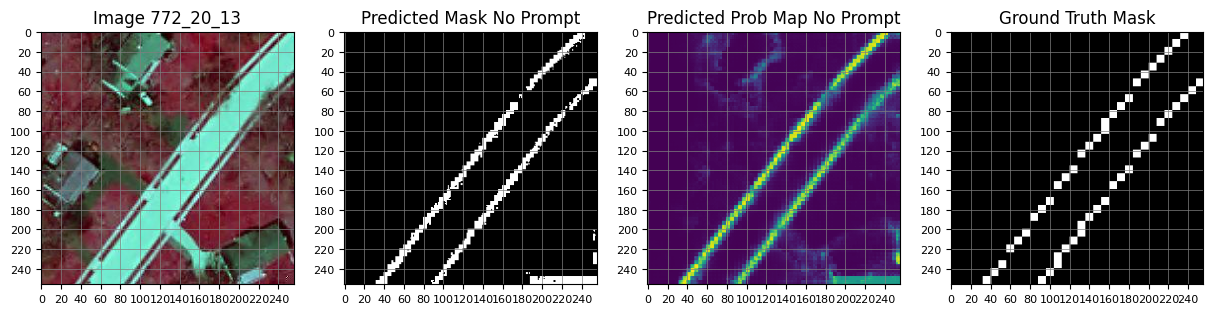

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


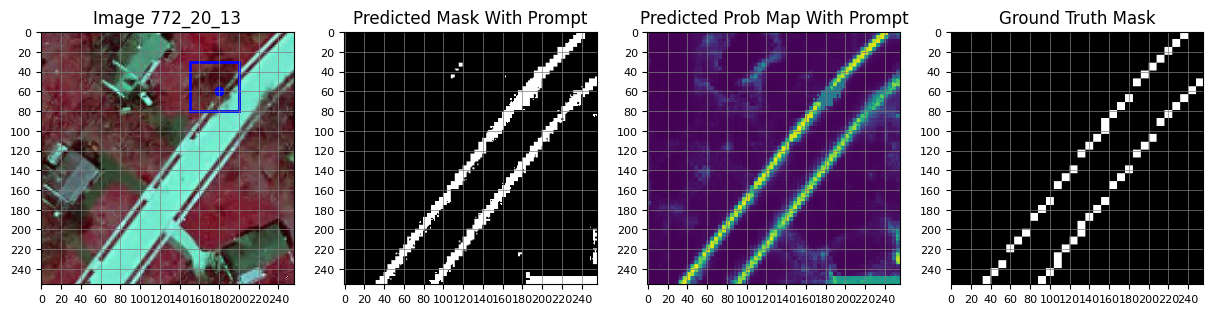

In [ ]:
get_mask_without_prompt(2269, filtered_dataset, processor, my_sw_model)
input_points_arr = np.array([
    [[0, 0] for _ in range(1)],  # to match the number of points in the second box
    [[180,60]]
])
input_labels_arr = [[1]]
bbox_user = [150,30,200,80]
sidewalk_prompter(2269, filtered_dataset, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.1, 0.6, bbox_user)

### Image 9

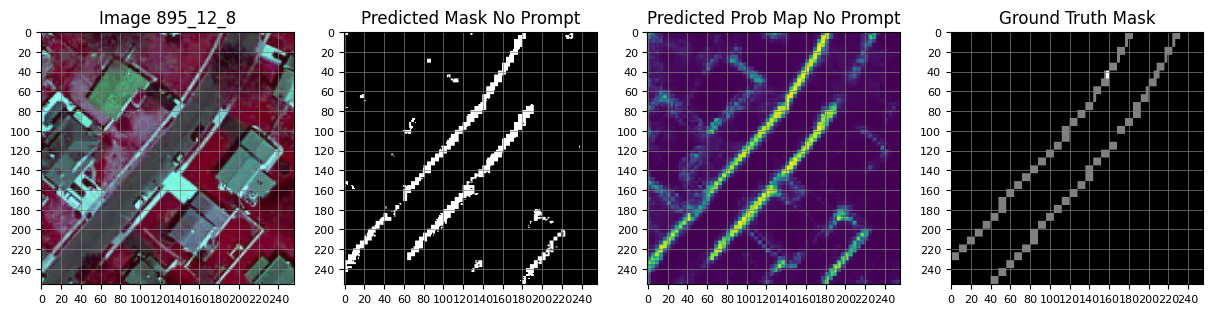

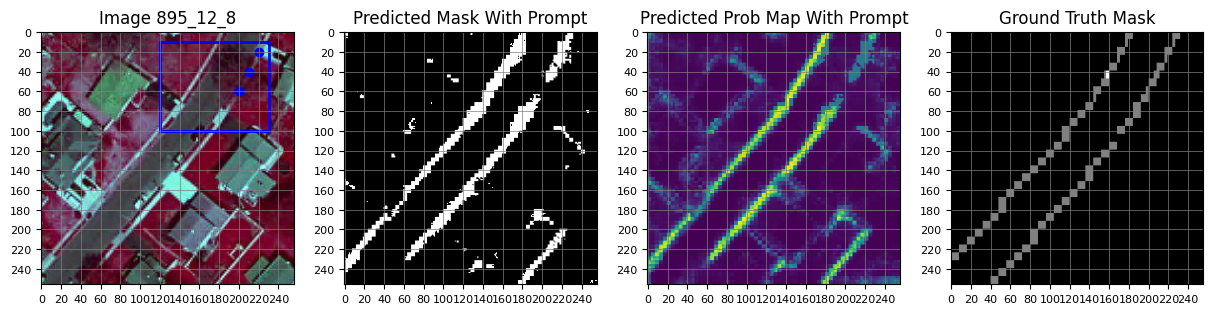

In [ ]:
get_mask_without_prompt(9088, filtered_dataset_val, processor, my_sw_model)
# input_points_arr = [[200,60]]
input_points_arr = np.array([
    [[0, 0] for _ in range(3)],  # to match the number of points in the second box
    [[220,20],[210,40],[200,60]]
])
input_labels_arr = [[1,1,1]]
bbox_user = [120,10,230,100]
sidewalk_prompter(9088, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.1, 0.6, bbox_user)

### Image 10

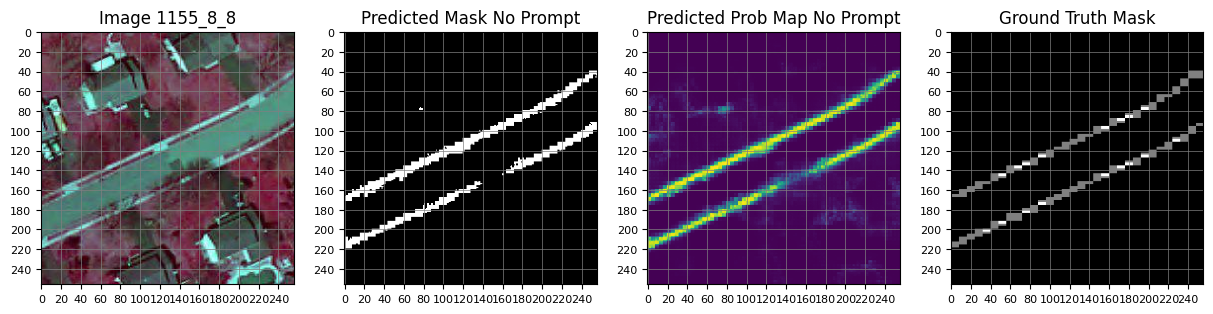

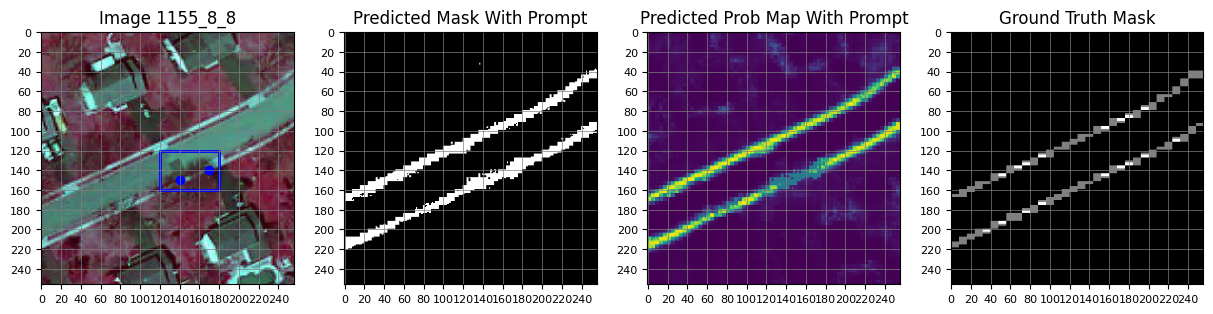

In [ ]:
get_mask_without_prompt(1588, filtered_dataset_val, processor, my_sw_model)
input_points_arr = np.array([
    [[0, 0] for _ in range(2)],  # to match the number of points in the second box
    [[140,150],[170,140]]
])
input_labels_arr = [[1,1]]
bbox_user = [120,120,180,160]
sidewalk_prompter(1588, filtered_dataset_val, processor, my_sw_model, model_lang, input_points_arr, input_labels_arr, 0.1, 0.6, bbox_user)

# Try centerline

In [ ]:
!pip install centerline

In [ ]:
!pip install scikit-image

In [ ]:
from centerline.geometry import Centerline
import shapely
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import numpy as np

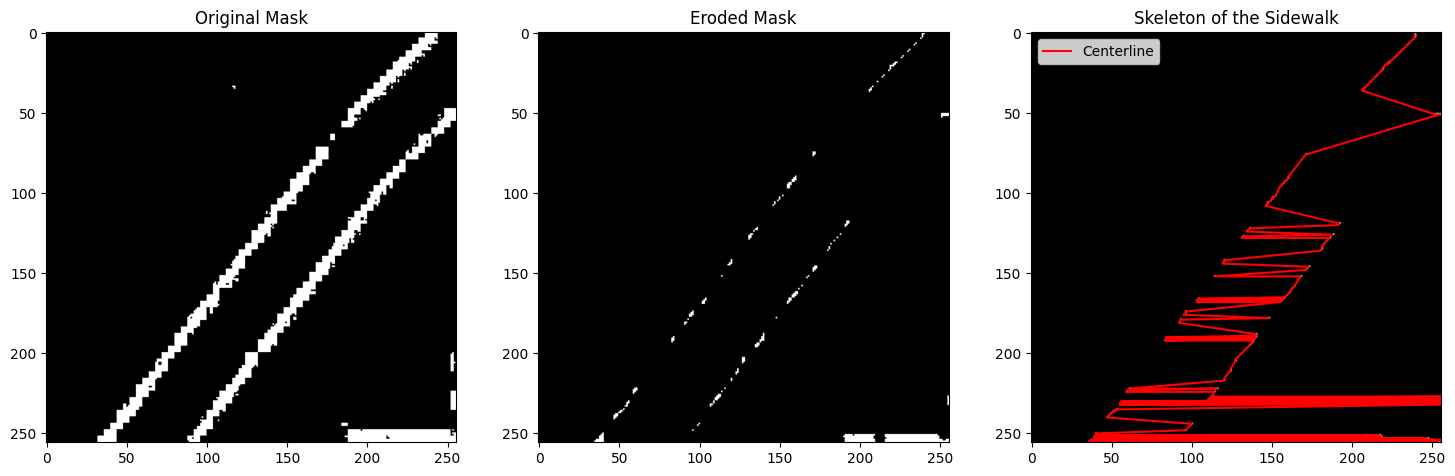

In [ ]:
from shapely.geometry import LineString, Polygon, MultiPolygon
from centerline.geometry import Centerline
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
from skimage.morphology import skeletonize
from skimage.morphology import skeletonize, binary_erosion, disk
from shapely.geometry import LineString

def sidewalk_prompter2(idx, filtered_dataset, processor, model, input_points_arr, input_labels_arr, bbox):
    input_points = torch.tensor(input_points_arr, dtype=torch.float).unsqueeze(0)
    input_labels = torch.tensor(input_labels_arr, dtype=torch.int).unsqueeze(0)
    sam_dataset = SAMDataset(dataset=filtered_dataset, processor=processor) # create an instance of SAMDataset
    item = sam_dataset[idx]
    image = item["image"]
    filename=filtered_dataset[idx]["filename"]
    ground_truth_mask = item["ground_truth_mask"]
    prompt = get_bounding_box(ground_truth_mask)
    input_boxes=[[prompt],[bbox]]
    inputs = processor(image, input_boxes=input_boxes, input_points=input_points, input_labels=input_labels, return_tensors="pt") # prepare image + box prompt for the model
    inputs['input_boxes'] = inputs['input_boxes'].view(1, 2, 4)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False) # forward pass
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)) # apply sigmoid
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze() # convert soft mask to hard mask
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    mask_layer = medsam_seg[0]

    selem = disk(3)
    eroded = binary_erosion(mask_layer, selem)

    skeleton = skeletonize(eroded)

    rows, cols = np.where(skeleton)
    points = np.column_stack((cols, rows))
    line = LineString(points)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(mask_layer, cmap='gray')
    ax[0].set_title('Original Mask')
    ax[1].imshow(eroded, cmap='gray')
    ax[1].set_title('Eroded Mask')
    ax[2].imshow(skeleton, cmap='gray')
    ax[2].set_title('Skeleton of the Sidewalk')
    x, y = line.xy
    ax[2].plot(x, y, color='red', label='Centerline')
    ax[2].legend()
    plt.show()

input_points_arr = np.array([
    [[0, 0] for _ in range(3)],  # to match the number of points in the second box
    [[60, 170], [100, 200], [120, 220]]
])
input_labels_arr = [[1, 1, 1]]
bbox = [40,160,140,240]

sidewalk_prompter2(2269, filtered_dataset, processor, my_sw_model, input_points_arr, input_labels_arr, bbox)


In [ ]:
from shapely.geometry import Polygon
from centerline.geometry import Centerline

polygon = Polygon([[0, 0], [0, 4], [4, 4], [4, 0]])
attributes = {"id": 1, "name": "polygon", "valid": True}

centerline = Centerline(polygon, **attributes)
centerline.id == 1
print(centerline.name)
# print(centerline.geoms)

polygon
